# Notebook 07: Customer Segmentation with Rule-Based Quadrants

Clustering gave useful signal, but not enough separation for reliable persona-style assignment.
So this notebook switches to deterministic segmentation where every user gets a stable, explainable label.

Clustering recap:
- Notebook 04 baseline: silhouette ~0.10
- Notebook 05 (all features): negative silhouette
- Notebook 06 (non-aisle): best result, ~0.19 at `k=2`

Given that profile, rule-based segmentation is the cleaner production choice.


## Setup

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)

BASE_DIR = Path('data')
FEATURES_PATH = BASE_DIR / 'features' / 'feature_matrix.parquet'
OUTPUT_DIR = BASE_DIR / 'segments'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CLUSTER_BASELINE_PATH = BASE_DIR / 'clusters' / 'clustering_metrics.csv'
CLUSTER_ALL_FEATURES_PATH = BASE_DIR / 'clusters' / 'ablation_all_features' / 'clustering_metrics_all_features.csv'
CLUSTER_NON_AISLE_PATH = BASE_DIR / 'clusters' / 'ablation_non_aisle_features' / 'clustering_metrics_non_aisle.csv'

print('Percentile-Based Customer Segmentation (Raw Behavioral Features)')
print('=' * 60)


Percentile-Based Customer Segmentation (Raw Behavioral Features)


## Load Data

In [14]:
# Load engineered user-level features (raw, pre-clustering-transform)
feature_matrix = pd.read_parquet(FEATURES_PATH)

# Keep non-aisle behavioral features for interpretable rule-based segmentation
behavioral_cols = [c for c in feature_matrix.columns if not c.lower().startswith('aisle_')]
behavioral = feature_matrix[behavioral_cols].copy()

print(f'Loaded {len(behavioral):,} users')
print(f'Behavioral features (non-aisle): {len(behavioral_cols)}')
print(f'Sample columns: {", ".join(behavioral_cols[:8])}')

required_cols = ['mean_days_between_orders', 'reorder_ratio']
missing_required = [c for c in required_cols if c not in behavioral.columns]
if missing_required:
    raise ValueError(f'Missing required columns for segmentation: {missing_required}')

print()
print('Clustering evidence recap')
print('-' * 60)
rows = []

if CLUSTER_BASELINE_PATH.exists():
    r = pd.read_csv(CLUSTER_BASELINE_PATH).iloc[0]
    rows.append({'approach': 'Notebook 04 baseline', 'silhouette': float(r['silhouette_score']), 'k': int(r['n_clusters'])})
if CLUSTER_ALL_FEATURES_PATH.exists():
    r = pd.read_csv(CLUSTER_ALL_FEATURES_PATH).iloc[0]
    rows.append({'approach': 'Notebook 05 all features', 'silhouette': float(r['silhouette_score']), 'k': int(r['n_clusters'])})
if CLUSTER_NON_AISLE_PATH.exists():
    r = pd.read_csv(CLUSTER_NON_AISLE_PATH).iloc[0]
    rows.append({'approach': 'Notebook 06 non-aisle', 'silhouette': float(r['silhouette_score']), 'k': int(r['n_clusters'])})

if rows:
    clustering_evidence = pd.DataFrame(rows).sort_values('silhouette', ascending=False).reset_index(drop=True)
    print(clustering_evidence.to_string(index=False))
    best = clustering_evidence.iloc[0]
    print()
    print(f"Best unsupervised option: {best['approach']} (silhouette={best['silhouette']:.3f}, k={int(best['k'])})")
else:
    clustering_evidence = pd.DataFrame(columns=['approach', 'silhouette', 'k'])
    print('No prior clustering metrics found; continuing with rule-based segmentation.')


Loaded 182,223 users
Behavioral features (non-aisle): 14
Sample columns: reorder_ratio, reorder_consistency, pct_reordered_products, mean_days_between_orders, cv_days_between_orders, mean_order_hour, std_order_hour, avg_basket_size

Clustering evidence recap
------------------------------------------------------------
                 approach  silhouette  k
   Notebook 06 non-aisle    0.190983  2
     Notebook 04 baseline    0.104910  3
Notebook 05 all features   -0.008005  3

Best unsupervised option: Notebook 06 non-aisle (silhouette=0.191, k=2)


## Calculate Segmentation Metrics

In [15]:
# Frequency score: orders/day proxy (higher means shops more frequently)
behavioral['freq_score'] = 1 / (behavioral['mean_days_between_orders'].clip(lower=0) + 1)

# Loyalty score: reorder ratio (already business-interpretable)
behavioral['loyalty_score'] = behavioral['reorder_ratio']

print('Metric Ranges')
print('-' * 60)
print(f"Frequency score (1/(days+1)): {behavioral['freq_score'].min():.4f} to {behavioral['freq_score'].max():.4f}")
print(f"Loyalty score (reorder_ratio): {behavioral['loyalty_score'].min():.4f} to {behavioral['loyalty_score'].max():.4f}")


Metric Ranges
------------------------------------------------------------
Frequency score (1/(days+1)): 0.0323 to 1.0000
Loyalty score (reorder_ratio): 0.0000 to 0.9895


## Define Thresholds

Use median splits for full user coverage (no leftover bucket), plus p20/p80 for diagnostics.


In [16]:
# Coverage thresholds (used for assignment)
freq_p50 = behavioral['freq_score'].median()
loyal_p50 = behavioral['loyalty_score'].median()

# Diagnostic thresholds (not used for assignment)
freq_p20 = behavioral['freq_score'].quantile(0.20)
freq_p80 = behavioral['freq_score'].quantile(0.80)
loyal_p20 = behavioral['loyalty_score'].quantile(0.20)
loyal_p80 = behavioral['loyalty_score'].quantile(0.80)

print('Segmentation Thresholds')
print('=' * 70)
print('Assignment thresholds (median split):')
print(f'  Frequency p50: {freq_p50:.6f}')
print(f'  Loyalty   p50: {loyal_p50:.6f}')

print()
print('Diagnostic thresholds (extreme checks):')
print(f'  Frequency p20/p80: {freq_p20:.6f} / {freq_p80:.6f}')
print(f'  Loyalty   p20/p80: {loyal_p20:.6f} / {loyal_p80:.6f}')


Segmentation Thresholds
Assignment thresholds (median split):
  Frequency p50: 0.065217
  Loyalty   p50: 0.463415

Diagnostic thresholds (extreme checks):
  Frequency p20/p80: 0.045455 / 0.105263
  Loyalty   p20/p80: 0.276423 / 0.651599


## Assign Segments (Full Coverage, 4 Quadrants)

Each user is assigned to one of four behavior quadrants using median frequency and median loyalty.


In [17]:
def assign_segment(row):
    freq = row['freq_score']
    loyal = row['loyalty_score']

    if freq >= freq_p50 and loyal >= loyal_p50:
        return 'Champions'
    if freq >= freq_p50 and loyal < loyal_p50:
        return 'Frequent Explorers'
    if freq < freq_p50 and loyal >= loyal_p50:
        return 'Loyal Occasionals'
    return 'At Risk'

behavioral['segment'] = behavioral.apply(assign_segment, axis=1)
segment_order = ['Champions', 'Frequent Explorers', 'Loyal Occasionals', 'At Risk']

seg_counts = behavioral['segment'].value_counts().reindex(segment_order, fill_value=0)
seg_pct = seg_counts / len(behavioral) * 100

print('Segment Distribution (4-way full coverage)')
print('=' * 70)
for seg in segment_order:
    print(f"{seg:20s} {int(seg_counts[seg]):>8,} users | {seg_pct[seg]:>5.2f}%")

print()
print(f'Total users assigned: {int(seg_counts.sum()):,} / {len(behavioral):,} (100.00%)')


Segment Distribution (4-way full coverage)
Champions              61,317 users | 33.65%
Frequent Explorers     30,055 users | 16.49%
Loyal Occasionals      29,851 users | 16.38%
At Risk                61,000 users | 33.48%

Total users assigned: 182,223 / 182,223 (100.00%)


## Statistical Validation

Validation is split into three parts:

1. **Definition sanity check** for assignment dimensions (`freq_score`, `loyalty_score`).
2. **Independent ANOVA** using metrics not used in assignment.
3. **Split-stability check** to verify profile consistency across user splits.

Limitation: true out-of-time validation needs time-sliced features, which are not available in this table.


In [18]:
# 1) Definition sanity check (expected separation, not independent evidence)
definition_metrics = ['freq_score', 'loyalty_score']
def_rows = []

for metric in definition_metrics:
    groups = [behavioral[behavioral['segment'] == s][metric].dropna().values for s in segment_order]
    if any(len(g) == 0 for g in groups):
        continue

    f_stat, p_val = stats.f_oneway(*groups)
    n_total = len(behavioral)
    k_groups = len(segment_order)
    eta_sq = (f_stat * (k_groups - 1)) / (f_stat * (k_groups - 1) + (n_total - k_groups)) if n_total > k_groups else np.nan
    def_rows.append({
        'metric': metric,
        'f_statistic': float(f_stat),
        'p_value': float(p_val),
        'eta_squared': float(eta_sq),
    })

definition_df = pd.DataFrame(def_rows).sort_values('eta_squared', ascending=False).reset_index(drop=True)

print('Definition sanity check (assignment metrics)')
print('=' * 90)
if not definition_df.empty:
    show = definition_df.copy()
    show['f_statistic'] = show['f_statistic'].map(lambda x: f'{x:.2f}')
    show['p_value'] = show['p_value'].map(lambda x: f'{x:.4g}')
    show['eta_squared'] = show['eta_squared'].map(lambda x: f'{x:.3f}')
    print(show.to_string(index=False))

print()
print('=' * 90)
print('Independent validation (metrics not used in assignment)')
print('=' * 90)

# 2) Independent-metric validation
candidate_metrics = [
    'avg_basket_size', 'unique_products', 'unique_aisles',
    'mean_order_hour', 'total_orders', 'reorder_consistency',
    'mean_days_between_orders', 'cv_days_between_orders'
]
validation_metrics = [m for m in candidate_metrics if m in behavioral.columns]

rows = []
n_total = len(behavioral)
k_groups = len(segment_order)

for metric in validation_metrics:
    groups = [behavioral[behavioral['segment'] == s][metric].dropna().values for s in segment_order]
    if any(len(g) == 0 for g in groups):
        continue

    f_stat, p_val = stats.f_oneway(*groups)
    eta_sq = (f_stat * (k_groups - 1)) / (f_stat * (k_groups - 1) + (n_total - k_groups)) if n_total > k_groups else np.nan

    if eta_sq >= 0.14:
        effect = 'Large'
    elif eta_sq >= 0.06:
        effect = 'Medium'
    elif eta_sq >= 0.01:
        effect = 'Small'
    else:
        effect = 'Negligible'

    rows.append({
        'metric': metric,
        'f_statistic': float(f_stat),
        'p_value': float(p_val),
        'significant': 'Yes' if p_val < 0.05 else 'No',
        'eta_squared': float(eta_sq),
        'effect_size': effect,
    })

validation_df = pd.DataFrame(rows).sort_values('eta_squared', ascending=False).reset_index(drop=True)

if not validation_df.empty:
    show = validation_df.copy()
    show['f_statistic'] = show['f_statistic'].map(lambda x: f'{x:.2f}')
    show['p_value'] = show['p_value'].map(lambda x: f'{x:.4g}')
    show['eta_squared'] = show['eta_squared'].map(lambda x: f'{x:.3f}')
    print(show.to_string(index=False))

    sig_count = (validation_df['significant'] == 'Yes').sum()
    print()
    print(f'Significant independent metrics: {sig_count}/{len(validation_df)}')
    print(f"Large effects: {(validation_df['effect_size'] == 'Large').sum()} | Medium effects: {(validation_df['effect_size'] == 'Medium').sum()}")
else:
    print('No independent metrics available for ANOVA.')

print()
print('=' * 90)
print('Split stability check (profile consistency across user splits)')
print('=' * 90)

# 3) Split-stability check (proxy when no temporal holdout is available)
rng = np.random.default_rng(42)
mask = rng.random(len(behavioral)) < 0.5
split_a = behavioral.loc[mask].copy()
split_b = behavioral.loc[~mask].copy()

stability_metrics = [m for m in ['freq_score', 'loyalty_score', 'avg_basket_size', 'unique_products'] if m in behavioral.columns]
stability_rows = []

for seg in segment_order:
    a_seg = split_a[split_a['segment'] == seg]
    b_seg = split_b[split_b['segment'] == seg]
    if len(a_seg) == 0 or len(b_seg) == 0:
        continue

    for m in stability_metrics:
        a_mean = float(a_seg[m].mean())
        b_mean = float(b_seg[m].mean())
        denom = max(abs(a_mean), 1e-9)
        rel_gap_pct = abs(a_mean - b_mean) / denom * 100
        stability_rows.append({
            'segment': seg,
            'metric': m,
            'split_a_mean': a_mean,
            'split_b_mean': b_mean,
            'relative_gap_pct': rel_gap_pct,
        })

stability_df = pd.DataFrame(stability_rows)
if not stability_df.empty:
    stability_summary = (
        stability_df.groupby('metric', as_index=False)['relative_gap_pct']
        .median()
        .rename(columns={'relative_gap_pct': 'median_relative_gap_pct'})
        .sort_values('median_relative_gap_pct')
    )
    print('Median relative gap by metric (lower is better):')
    print(stability_summary.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
else:
    stability_summary = pd.DataFrame(columns=['metric', 'median_relative_gap_pct'])
    print('Stability check unavailable.')


Definition sanity check (assignment metrics)
       metric f_statistic p_value eta_squared
loyalty_score   148340.66       0       0.709
   freq_score    52335.48       0       0.463

Independent validation (metrics not used in assignment)
                  metric f_statistic    p_value significant eta_squared effect_size
mean_days_between_orders   147106.09          0         Yes       0.708       Large
  cv_days_between_orders    20279.57          0         Yes       0.250       Large
         unique_products    12911.87          0         Yes       0.175       Large
           unique_aisles     9096.43          0         Yes       0.130      Medium
     reorder_consistency     2492.00          0         Yes       0.039       Small
         avg_basket_size     1512.18          0         Yes       0.024       Small
         mean_order_hour      344.67 3.258e-223         Yes       0.006  Negligible

Significant independent metrics: 7/7
Large effects: 3 | Medium effects: 1

Split stabil

## Segment Profiles

Profile means are computed for all users across the four final segments.


In [19]:
profile_metrics = ['freq_score', 'loyalty_score', 'avg_basket_size',
                   'unique_products', 'total_orders']
profile_metrics = [m for m in profile_metrics if m in behavioral.columns]

profiles = behavioral.groupby('segment')[profile_metrics].mean().reindex(segment_order)

print('Segment Profiles (Mean Values)')
print('=' * 80)
print(profiles.round(3).to_string())

profiles.to_csv(OUTPUT_DIR / 'segment_profiles_percentile.csv')
print()
print(f"Saved to {OUTPUT_DIR / 'segment_profiles_percentile.csv'}")


Segment Profiles (Mean Values)
                    freq_score  loyalty_score  avg_basket_size  unique_products
segment                                                                        
Champions                0.114          0.653           10.046          103.075
Frequent Explorers       0.099          0.317            8.198           64.776
Loyal Occasionals        0.051          0.583            9.537           52.412
At Risk                  0.047          0.285            8.295           48.025

Saved to data/segments/segment_profiles_percentile.csv


## Segment Characterization

Two label layers are used on purpose:

- **Analytical labels** (for technical clarity):
  - HighFreq-HighLoyal
  - HighFreq-LowLoyal
  - LowFreq-HighLoyal
  - LowFreq-LowLoyal

- **Business labels** (for stakeholder communication):
  - Champions
  - Frequent Explorers
  - Loyal Occasionals
  - At Risk


In [20]:
print('=' * 80)
print('SEGMENT INSIGHTS')
print('=' * 80)

analytic_map = {
    'Champions': 'HighFreq-HighLoyal',
    'Frequent Explorers': 'HighFreq-LowLoyal',
    'Loyal Occasionals': 'LowFreq-HighLoyal',
    'At Risk': 'LowFreq-LowLoyal',
}

summary = (
    behavioral.groupby('segment')
    .agg(
        users=('segment', 'size'),
        avg_freq_score=('freq_score', 'mean'),
        avg_loyalty_score=('loyalty_score', 'mean')
    )
    .reset_index()
    .set_index('segment')
    .reindex(segment_order)
    .reset_index()
)
summary['pct_total'] = summary['users'] / len(behavioral) * 100

print('Metric definition:')
print('  - Frequency score: 1 / (mean_days_between_orders + 1)')
print('  - Loyalty score: reorder_ratio')

print()
print('Per-segment interpretation:')
for _, row in summary.iterrows():
    seg = row['segment']
    users = int(row['users'])
    pct_t = float(row['pct_total'])
    freq_s = float(row['avg_freq_score'])
    loyal_s = float(row['avg_loyalty_score'])

    print()
    print(f"{seg.upper()} ({analytic_map.get(seg, 'N/A')})")
    print(f'  Size: {users:,} users ({pct_t:.2f}%)')
    print(f'  Avg frequency score: {freq_s:.4f} | Avg loyalty score: {loyal_s:.4f}')

    if seg == 'Champions':
        print('  Action: protect value with loyalty perks and premium retention offers.')
    elif seg == 'Frequent Explorers':
        print('  Action: increase repeat intent with reorder nudges and habit-forming bundles.')
    elif seg == 'Loyal Occasionals':
        print('  Action: increase order cadence using timing-based reminders and convenience hooks.')
    elif seg == 'At Risk':
        print('  Action: run win-back tests with strict ROI guardrails.')

print()
print('-' * 80)
print('Validation readout from this run:')
print('  - Strong independent separation on cv_days_between_orders and unique_products (large effects).')
print('  - unique_aisles shows medium separation; avg_basket_size and reorder_consistency are smaller effects.')
print('  - mean_order_hour is statistically significant but practically negligible.')
print('  - mean_days_between_orders is not counted as independent evidence because it is algebraically tied to freq_score.')
print('  - Split-stability is strong (all reported median relative gaps are <1%).')

print()
print('Portfolio framing: full-coverage deterministic segmentation for campaign operations,')
print('with independent-metric validation and explicit limitations documented.')


SEGMENT INSIGHTS
Metric definition:
  - Frequency score: 1 / (mean_days_between_orders + 1)
  - Loyalty score: reorder_ratio

Per-segment interpretation:

CHAMPIONS (HighFreq-HighLoyal)
  Size: 61,317 users (33.65%)
  Avg frequency score: 0.1137 | Avg loyalty score: 0.6532
  Action: protect value with loyalty perks and premium retention offers.

FREQUENT EXPLORERS (HighFreq-LowLoyal)
  Size: 30,055 users (16.49%)
  Avg frequency score: 0.0991 | Avg loyalty score: 0.3165
  Action: increase repeat intent with reorder nudges and habit-forming bundles.

LOYAL OCCASIONALS (LowFreq-HighLoyal)
  Size: 29,851 users (16.38%)
  Avg frequency score: 0.0509 | Avg loyalty score: 0.5825
  Action: increase order cadence using timing-based reminders and convenience hooks.

AT RISK (LowFreq-LowLoyal)
  Size: 61,000 users (33.48%)
  Avg frequency score: 0.0474 | Avg loyalty score: 0.2849
  Action: run win-back tests with strict ROI guardrails.

-----------------------------------------------------------

## Visualization: Segment Scatter

Scatter plot of all users with 4-way quadrant labels.


Visualizing 12,000 sampled users


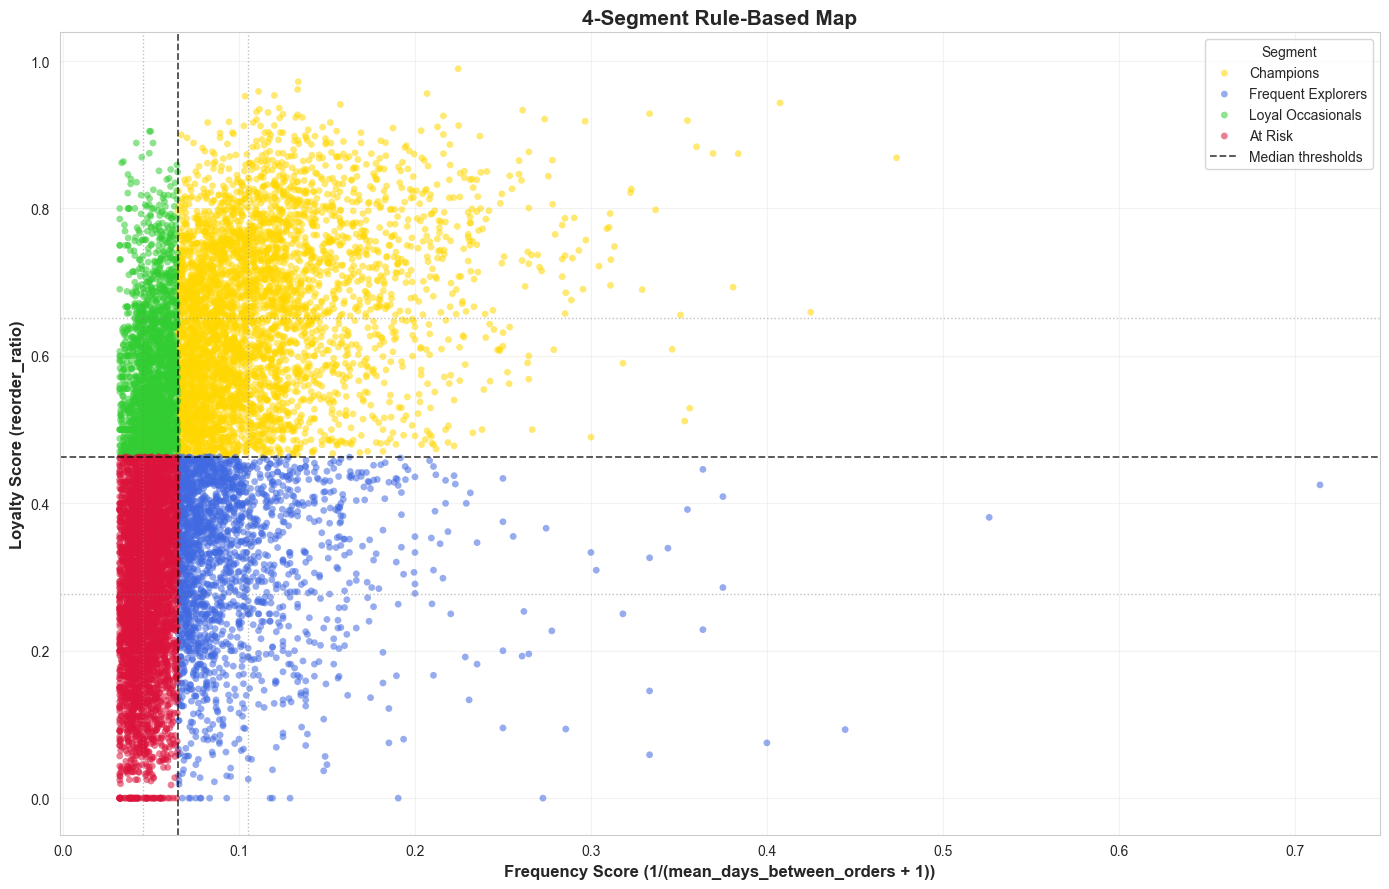


Saved to data/segments/segmentation_percentile.png


In [21]:
np.random.seed(42)
n_sample = min(12000, len(behavioral))
viz_data = behavioral.sample(n=n_sample, random_state=42)

print(f'Visualizing {len(viz_data):,} sampled users')

fig, ax = plt.subplots(figsize=(14, 9))

colors = {
    'Champions': '#FFD700',
    'Frequent Explorers': '#4169E1',
    'Loyal Occasionals': '#32CD32',
    'At Risk': '#DC143C',
}

for seg in segment_order:
    data = viz_data[viz_data['segment'] == seg]
    if len(data) > 0:
        ax.scatter(
            data['freq_score'],
            data['loyalty_score'],
            c=colors[seg],
            label=seg,
            alpha=0.55,
            s=24,
            edgecolors='none',
        )

# Median boundaries (assignment logic)
ax.axvline(freq_p50, color='black', linestyle='--', linewidth=1.3, alpha=0.7, label='Median thresholds')
ax.axhline(loyal_p50, color='black', linestyle='--', linewidth=1.3, alpha=0.7)

# Optional diagnostic percentile lines
ax.axvline(freq_p20, color='gray', linestyle=':', linewidth=1.0, alpha=0.5)
ax.axvline(freq_p80, color='gray', linestyle=':', linewidth=1.0, alpha=0.5)
ax.axhline(loyal_p20, color='gray', linestyle=':', linewidth=1.0, alpha=0.5)
ax.axhline(loyal_p80, color='gray', linestyle=':', linewidth=1.0, alpha=0.5)

ax.set_xlabel('Frequency Score (1/(mean_days_between_orders + 1))', fontsize=12, weight='bold')
ax.set_ylabel('Loyalty Score (reorder_ratio)', fontsize=12, weight='bold')
ax.set_title('4-Segment Rule-Based Map', fontsize=15, weight='bold')
ax.legend(title='Segment', loc='best', frameon=True)
ax.grid(alpha=0.25)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'segmentation_percentile.png', dpi=150, bbox_inches='tight')
plt.show()

print()
print(f"Saved to {OUTPUT_DIR / 'segmentation_percentile.png'}")


## Visualization: Distribution Comparison

Box plots showing how segments differ on key metrics.

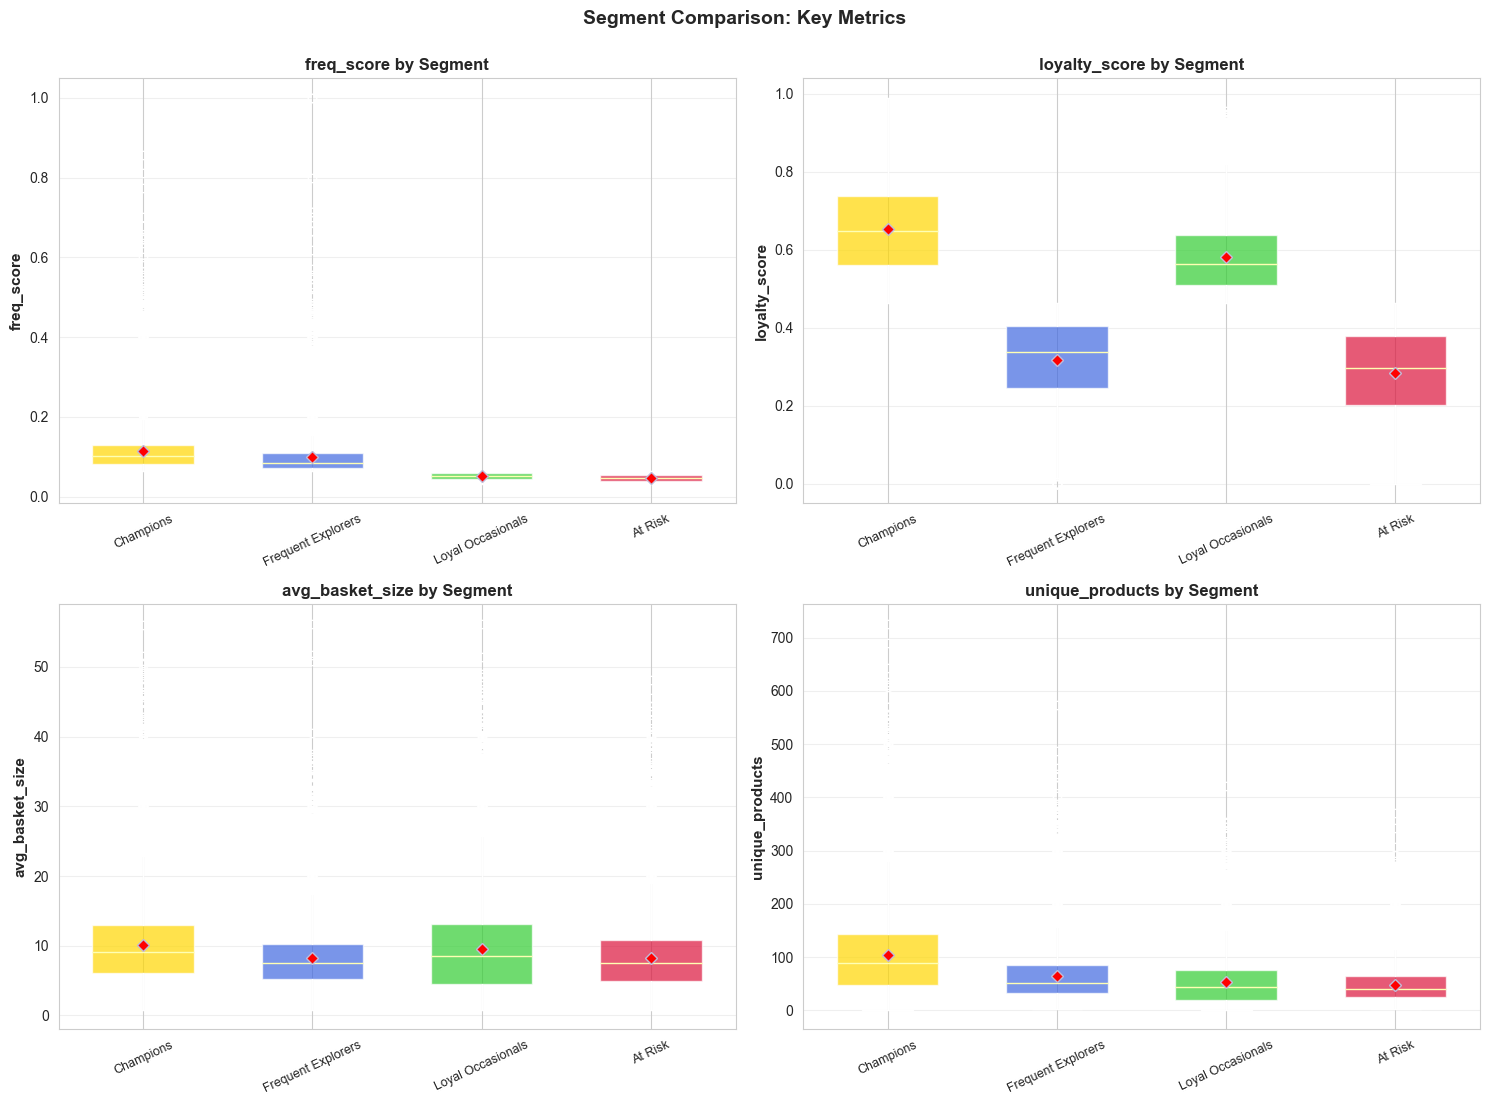

Saved to data/segments/segment_distributions_percentile.png


In [22]:
plot_metrics = profile_metrics[:4] if len(profile_metrics) >= 4 else profile_metrics

fig, axes = plt.subplots(2, 2, figsize=(15, 11))
axes = axes.flatten()

for idx, metric in enumerate(plot_metrics):
    ax = axes[idx]

    data = []
    labels = []
    colors_list = []

    for seg in segment_order:
        seg_values = behavioral[behavioral['segment'] == seg][metric].values
        if len(seg_values) > 0:
            data.append(seg_values)
            labels.append(seg)
            colors_list.append(colors[seg])

    bp = ax.boxplot(
        data,
        labels=labels,
        patch_artist=True,
        showmeans=True,
        meanprops=dict(marker='D', markerfacecolor='red', markersize=6),
        widths=0.6,
    )

    for patch, color in zip(bp['boxes'], colors_list):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_ylabel(metric, fontsize=11, weight='bold')
    ax.set_title(f'{metric} by Segment', fontsize=12, weight='bold')
    ax.tick_params(axis='x', rotation=25, labelsize=9)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Segment Comparison: Key Metrics', fontsize=14, weight='bold', y=1.00)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'segment_distributions_percentile.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved to {OUTPUT_DIR / 'segment_distributions_percentile.png'}")


## Export Results

In [23]:
# Export full-coverage assignments
assignments = behavioral[['segment', 'freq_score', 'loyalty_score']].copy()
assignments.to_parquet(OUTPUT_DIR / 'segment_assignments_percentile.parquet', index=True)
assignments.to_csv(OUTPUT_DIR / 'segment_assignments_percentile.csv', index=True)

print('Saved:')
print(f"  {OUTPUT_DIR / 'segment_assignments_percentile.parquet'}")
print(f"  {OUTPUT_DIR / 'segment_assignments_percentile.csv'}")

# Segment summary
size_analysis = []
for seg in segment_order:
    seg_data = behavioral[behavioral['segment'] == seg]
    size_analysis.append({
        'segment': seg,
        'count': len(seg_data),
        'percentage': len(seg_data) / len(behavioral) * 100,
        'avg_frequency_score': seg_data['freq_score'].mean() if len(seg_data) else np.nan,
        'avg_loyalty_score': seg_data['loyalty_score'].mean() if len(seg_data) else np.nan,
    })

size_df = pd.DataFrame(size_analysis)
size_df.to_csv(OUTPUT_DIR / 'segment_summary_percentile.csv', index=False)
print(f"  {OUTPUT_DIR / 'segment_summary_percentile.csv'}")

# Thresholds
thresholds = pd.DataFrame([
    {'metric': 'frequency', 'percentile': 'p20', 'value': freq_p20},
    {'metric': 'frequency', 'percentile': 'p50', 'value': freq_p50},
    {'metric': 'frequency', 'percentile': 'p80', 'value': freq_p80},
    {'metric': 'loyalty', 'percentile': 'p20', 'value': loyal_p20},
    {'metric': 'loyalty', 'percentile': 'p50', 'value': loyal_p50},
    {'metric': 'loyalty', 'percentile': 'p80', 'value': loyal_p80},
])
thresholds.to_csv(OUTPUT_DIR / 'thresholds_percentile.csv', index=False)
print(f"  {OUTPUT_DIR / 'thresholds_percentile.csv'}")

# Validation exports
if 'validation_df' in locals() and not validation_df.empty:
    validation_df.to_csv(OUTPUT_DIR / 'anova_results.csv', index=False)
    print(f"  {OUTPUT_DIR / 'anova_results.csv'}")
if 'definition_df' in locals() and not definition_df.empty:
    definition_df.to_csv(OUTPUT_DIR / 'definition_sanity_check.csv', index=False)
    print(f"  {OUTPUT_DIR / 'definition_sanity_check.csv'}")
if 'stability_df' in locals() and not stability_df.empty:
    stability_df.to_csv(OUTPUT_DIR / 'split_stability_details.csv', index=False)
    print(f"  {OUTPUT_DIR / 'split_stability_details.csv'}")
if 'stability_summary' in locals() and not stability_summary.empty:
    stability_summary.to_csv(OUTPUT_DIR / 'split_stability_summary.csv', index=False)
    print(f"  {OUTPUT_DIR / 'split_stability_summary.csv'}")


Saved:
  data/segments/segment_assignments_percentile.parquet
  data/segments/segment_assignments_percentile.csv
  data/segments/segment_summary_percentile.csv
  data/segments/thresholds_percentile.csv
  data/segments/anova_results.csv
  data/segments/definition_sanity_check.csv
  data/segments/split_stability_details.csv
  data/segments/split_stability_summary.csv


## Comparison: Clustering vs Rule-Based 4-Segment

This section clarifies role, not winner-takes-all.

- Clustering: good for unsupervised structure diagnostics.
- Rule-based segmentation: better for stable, full-coverage operational assignment.


In [24]:
comparison = pd.DataFrame({
    'Criterion': [
        'Primary objective',
        'Separation quality in this project',
        'Interpretability for stakeholders',
        'Assignment stability',
        'Coverage',
        'Campaign readiness',
        'Best use in this portfolio',
    ],
    'Clustering (04/04b/04c)': [
        'Discover natural structure',
        'Improved to ~0.19 at best, still moderate/weak',
        'Medium (needs model context)',
        'Depends on feature set and k',
        'High (all users assigned)',
        'Medium',
        'Exploratory evidence + model diagnostics',
    ],
    'Rule-Based 4-Segment (Notebook 05)': [
        'Operational segmentation for all users',
        'Deterministic quadrant boundaries',
        'High (plain-language thresholds)',
        'High (deterministic)',
        'High (all users assigned)',
        'High',
        'Production-facing lifecycle segmentation',
    ],
})

print('Method Comparison')
print('=' * 100)
print(comparison.to_string(index=False))

comparison.to_csv(OUTPUT_DIR / 'comparison_percentile.csv', index=False)


Method Comparison
                         Criterion                        Clustering (04/04b/04c)       Rule-Based 4-Segment (Notebook 05)
                 Primary objective                     Discover natural structure   Operational segmentation for all users
Separation quality in this project Improved to ~0.19 at best, still moderate/weak        Deterministic quadrant boundaries
 Interpretability for stakeholders                   Medium (needs model context)         High (plain-language thresholds)
              Assignment stability                   Depends on feature set and k                     High (deterministic)
                          Coverage                      High (all users assigned)                High (all users assigned)
                Campaign readiness                                         Medium                                     High
        Best use in this portfolio       Exploratory evidence + model diagnostics Production-facing lifecycle segmentatio

## Key Takeaways

1. **The 4-segment framework is working as intended.**  
Every user is assigned using deterministic, reproducible rules.

2. **Independent validation is meaningful.**  
This run shows large effects for `cv_days_between_orders` and `unique_products`, plus medium effect for `unique_aisles`.

3. **Practical significance is handled correctly.**  
`mean_order_hour` is statistically significant but practically negligible, so it should not drive strategy.

4. **Claims are scoped to valid evidence.**  
`mean_days_between_orders` is not used as independent proof because it is directly tied to `freq_score` in the assignment logic.

5. **Stability is strong.**  
Split-stability median relative gaps are below 1%, indicating robust segment profiles.

6. **Final recommendation is clear.**  
Use this rule-based framework as the production segmentation layer, with clustering kept as supporting exploratory context.
